In [1]:
import spacy
import gensim
import pandas as pd
import nltk
import numpy as np
import re
import string
import xgboost as xgb

from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from gensim.models.fasttext import FastText
from MeanVectorizer import MeanEmbeddingVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

nltk.download('punkt')
nlp = spacy.blank('id')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\egapa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_excel("dataset1000.xlsx")
df.head()

,label,komentar
0,positif,Oke pak boss!!
1,positif,PROBOWO is the WINNER of PEMILU 2014
2,positif,Hidup Pak Prabowo ..
3,positif,Ganteng bgt Pak :)
4,positif,ayo pak rujuk lagi sama bu titiek..hehhehe


In [3]:
df['label'].value_counts()

positif    1549
negatif     332
netral      120
Name: label, dtype: int64

In [4]:
komentar = df['komentar'].astype(str)

#Lower case
komentar = komentar.apply(lambda x: x.lower())

#Remove URL
komentar = komentar.apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))

#Remove Number
komentar = komentar.apply(lambda x: re.sub(r"\d", "", x))

#Before Punctuation
komentar = komentar.apply(lambda x: re.sub(r'(?<=[,.])(?=[^\s])', r' ', x))

#Punctuation
komentar = komentar.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

#Remove Non Alphanumeric
komentar = komentar.apply(lambda x: re.sub(r'([^\s\w]|_)+', '', x))

#Tokenizing
komentar = komentar.apply(lambda x: nltk.tokenize.word_tokenize(x))

df['komentar'] = komentar
df

,label,komentar
0,positif,"[oke, pak, boss]"
1,positif,"[probowo, is, the, winner, of, pemilu]"
2,positif,"[hidup, pak, prabowo]"
3,positif,"[ganteng, bgt, pak]"
4,positif,"[ayo, pak, rujuk, lagi, sama, bu, titiek, hehh..."
...,...,...
1996,negatif,"[jangan, lupa, n, jangan, dugal, y, buat, yg, ..."
1997,negatif,"[no, we]"
1998,negatif,"[pasang, foto, biar, laku, ya, joko, xixixixi]"
1999,negatif,"[gw, pilih, no, prabowo, hata]"


In [5]:
df_tambahan = pd.read_excel("dataset_tambahan.xlsx")
df_tambahan

,label,komentar
0,negatif,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu..."
1,negatif,"Sesama cewe lho (kayaknya), harusnya bisa lebi..."
2,negatif,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng..."
3,negatif,"Dari sekian banyak thread yang aku baca, threa..."
4,negatif,"Contoh mereka yg gemar menyudutkan, teriak pal..."
...,...,...
2093,netral,bukan saya yang tidak-mau merit sat ini hubung...
2094,netral,Baru lihat kabar Teman nge gosip dan penuh inf...
2095,netral,Mengubah kebiasaan seseorang yg kurang baik it...
2096,netral,nah diam lebih bagus yaudah saya diam saja deh...


In [6]:
komentar = df_tambahan['komentar'].astype(str)

#Lower case
komentar = komentar.apply(lambda x: x.lower())

#Remove URL
komentar = komentar.apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))

#Remove Number
komentar = komentar.apply(lambda x: re.sub(r"\d", "", x))

#Before Punctuation
komentar = komentar.apply(lambda x: re.sub(r'(?<=[,.])(?=[^\s])', r' ', x))

#Punctuation
komentar = komentar.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

#Remove Non Alphanumeric
komentar = komentar.apply(lambda x: re.sub(r'([^\s\w]|_)+', '', x))

#Tokenizing
komentar = komentar.apply(lambda x: nltk.tokenize.word_tokenize(x))

df_tambahan['komentar'] = komentar
df_tambahan

,label,komentar
0,negatif,"[soal, jln, jatibaru, polisi, tdk, bs, gertak,..."
1,negatif,"[sesama, cewe, lho, kayaknya, harusnya, bisa, ..."
2,negatif,"[jln, jatibaru, bagian, dari, wilayah, tn, aba..."
3,negatif,"[dari, sekian, banyak, thread, yang, aku, baca..."
4,negatif,"[contoh, mereka, yg, gemar, menyudutkan, teria..."
...,...,...
2093,netral,"[bukan, saya, yang, tidakmau, merit, sat, ini,..."
2094,netral,"[baru, lihat, kabar, teman, nge, gosip, dan, p..."
2095,netral,"[mengubah, kebiasaan, seseorang, yg, kurang, b..."
2096,netral,"[nah, diam, lebih, bagus, yaudah, saya, diam, ..."


In [7]:
df = df[df.komentar.astype(bool)]
df_tambahan = df_tambahan[df_tambahan.komentar.astype(bool)]

X_temp = df['komentar']
y = df['label']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
X_train = X_train.append(df_tambahan.komentar)
y_train = y_train.append(df_tambahan.label)
y_train.value_counts()

negatif    1364
positif    1237
netral     1085
Name: label, dtype: int64

In [10]:
model = FastText.load('Model/XGB.bin')

In [11]:
mean_vec_tr = MeanEmbeddingVectorizer(model)

In [12]:
X_train_vector = mean_vec_tr.transform(X_train)
X_test_vector = mean_vec_tr.transform(X_test)

In [13]:
lc=preprocessing.LabelEncoder()
lc.fit(y)

LabelEncoder()

In [14]:
y_train_enc=lc.transform(y_train)
y_test_enc=lc.transform(y_test)

In [15]:
weights = y_train_enc
weights = np.choose(weights, [1, 1.25, 1.1])

train=xgb.DMatrix(X_train_vector,label=y_train_enc, weight=weights)
test=xgb.DMatrix(X_test_vector,label=y_test_enc)

print("\nIni Weights\n", weights, "\n")
print("Ini y_train_encode\n", y_train_enc, "\n")


Ini Weights
 [1.25 1.25 1.   ... 1.25 1.25 1.25] 

Ini y_train_encode
 [1 1 0 ... 1 1 1] 



In [16]:
param = {}

# Learning Rate:  0.01
# Gamma:  0.3
# Max Depth:  7
# Subsample:  0.4
# Colsample Bytree:  0.6
# Alpha:  0
# Lamda:  1.5
# Min Child Weight:  1
# Number of Trees:  1000

param['num_class']=len(set(y))
param['objective'] = 'multi:softmax'
param['learning_rate'] = 0.01
param['gamma'] = 0.3
param['max_depth'] = 4
param['subsample'] = 0.4
param['colsample_bytree'] = 0.6
param['reg_alpha'] = 0
param['reg_lambda'] = 1.5
param['min_child_weight'] = 1
num_round = 1000

watchlist = [(train, 'train'), (test, 'test')]
bst = xgb.train(param, train, num_round, watchlist)

[0]	train-merror:0.38721	test-merror:0.37688
[1]	train-merror:0.32078	test-merror:0.33668
[2]	train-merror:0.30757	test-merror:0.33417
[3]	train-merror:0.29324	test-merror:0.31910
[4]	train-merror:0.28858	test-merror:0.30151
[5]	train-merror:0.27747	test-merror:0.28643
[6]	train-merror:0.26474	test-merror:0.28392
[7]	train-merror:0.26070	test-merror:0.28643
[8]	train-merror:0.25579	test-merror:0.28392
[9]	train-merror:0.25305	test-merror:0.28392
[10]	train-merror:0.25125	test-merror:0.28643
[11]	train-merror:0.24548	test-merror:0.28643
[12]	train-merror:0.24174	test-merror:0.27889
[13]	train-merror:0.24119	test-merror:0.27638
[14]	train-merror:0.24339	test-merror:0.26884
[15]	train-merror:0.23716	test-merror:0.27387
[16]	train-merror:0.23361	test-merror:0.27387
[17]	train-merror:0.23292	test-merror:0.27638
[18]	train-merror:0.23037	test-merror:0.27889
[19]	train-merror:0.23024	test-merror:0.28392
[20]	train-merror:0.22442	test-merror:0.29146
[21]	train-merror:0.22674	test-merror:0.2864

[177]	train-merror:0.16793	test-merror:0.25377
[178]	train-merror:0.16735	test-merror:0.25879
[179]	train-merror:0.16674	test-merror:0.25628
[180]	train-merror:0.16557	test-merror:0.25879
[181]	train-merror:0.16465	test-merror:0.25628
[182]	train-merror:0.16561	test-merror:0.25628
[183]	train-merror:0.16419	test-merror:0.25126
[184]	train-merror:0.16572	test-merror:0.25377
[185]	train-merror:0.16439	test-merror:0.25377
[186]	train-merror:0.16447	test-merror:0.25377
[187]	train-merror:0.16391	test-merror:0.25377
[188]	train-merror:0.16510	test-merror:0.25377
[189]	train-merror:0.16401	test-merror:0.25377
[190]	train-merror:0.16452	test-merror:0.25126
[191]	train-merror:0.16367	test-merror:0.25377
[192]	train-merror:0.16425	test-merror:0.25377
[193]	train-merror:0.16419	test-merror:0.25628
[194]	train-merror:0.16413	test-merror:0.25377
[195]	train-merror:0.16413	test-merror:0.25377
[196]	train-merror:0.16284	test-merror:0.25126
[197]	train-merror:0.16260	test-merror:0.25126
[198]	train-m

[352]	train-merror:0.13535	test-merror:0.25377
[353]	train-merror:0.13504	test-merror:0.25377
[354]	train-merror:0.13443	test-merror:0.25628
[355]	train-merror:0.13388	test-merror:0.25628
[356]	train-merror:0.13363	test-merror:0.25628
[357]	train-merror:0.13312	test-merror:0.25628
[358]	train-merror:0.13342	test-merror:0.25377
[359]	train-merror:0.13367	test-merror:0.25377
[360]	train-merror:0.13373	test-merror:0.25377
[361]	train-merror:0.13373	test-merror:0.25377
[362]	train-merror:0.13287	test-merror:0.25126
[363]	train-merror:0.13287	test-merror:0.25126
[364]	train-merror:0.13236	test-merror:0.25126
[365]	train-merror:0.13349	test-merror:0.25126
[366]	train-merror:0.13373	test-merror:0.25126
[367]	train-merror:0.13404	test-merror:0.25377
[368]	train-merror:0.13285	test-merror:0.25377
[369]	train-merror:0.13254	test-merror:0.25879
[370]	train-merror:0.13291	test-merror:0.25628
[371]	train-merror:0.13318	test-merror:0.25126
[372]	train-merror:0.13184	test-merror:0.25126
[373]	train-m

[527]	train-merror:0.10999	test-merror:0.24874
[528]	train-merror:0.11035	test-merror:0.24874
[529]	train-merror:0.10980	test-merror:0.24874
[530]	train-merror:0.10926	test-merror:0.24874
[531]	train-merror:0.10847	test-merror:0.24874
[532]	train-merror:0.10871	test-merror:0.24874
[533]	train-merror:0.10795	test-merror:0.24874
[534]	train-merror:0.10774	test-merror:0.25126
[535]	train-merror:0.10823	test-merror:0.25126
[536]	train-merror:0.10799	test-merror:0.25126
[537]	train-merror:0.10830	test-merror:0.25126
[538]	train-merror:0.10750	test-merror:0.25126
[539]	train-merror:0.10695	test-merror:0.25126
[540]	train-merror:0.10609	test-merror:0.25126
[541]	train-merror:0.10670	test-merror:0.25126
[542]	train-merror:0.10670	test-merror:0.25126
[543]	train-merror:0.10515	test-merror:0.25126
[544]	train-merror:0.10625	test-merror:0.25126
[545]	train-merror:0.10567	test-merror:0.25126
[546]	train-merror:0.10482	test-merror:0.24874
[547]	train-merror:0.10451	test-merror:0.25126
[548]	train-m

[702]	train-merror:0.08346	test-merror:0.25377
[703]	train-merror:0.08285	test-merror:0.25377
[704]	train-merror:0.08291	test-merror:0.25377
[705]	train-merror:0.08318	test-merror:0.25377
[706]	train-merror:0.08291	test-merror:0.25377
[707]	train-merror:0.08291	test-merror:0.25377
[708]	train-merror:0.08346	test-merror:0.25377
[709]	train-merror:0.08297	test-merror:0.25377
[710]	train-merror:0.08297	test-merror:0.25377
[711]	train-merror:0.08242	test-merror:0.25377
[712]	train-merror:0.08266	test-merror:0.25377
[713]	train-merror:0.08297	test-merror:0.25377
[714]	train-merror:0.08297	test-merror:0.25377
[715]	train-merror:0.08270	test-merror:0.25377
[716]	train-merror:0.08297	test-merror:0.25377
[717]	train-merror:0.08215	test-merror:0.25377
[718]	train-merror:0.08297	test-merror:0.25377
[719]	train-merror:0.08217	test-merror:0.25377
[720]	train-merror:0.08181	test-merror:0.25377
[721]	train-merror:0.08101	test-merror:0.25377
[722]	train-merror:0.08132	test-merror:0.25377
[723]	train-m

[877]	train-merror:0.06081	test-merror:0.24874
[878]	train-merror:0.06032	test-merror:0.24874
[879]	train-merror:0.06032	test-merror:0.24874
[880]	train-merror:0.06007	test-merror:0.24874
[881]	train-merror:0.06032	test-merror:0.24874
[882]	train-merror:0.06005	test-merror:0.24874
[883]	train-merror:0.06007	test-merror:0.24874
[884]	train-merror:0.05980	test-merror:0.24874
[885]	train-merror:0.05974	test-merror:0.24874
[886]	train-merror:0.05974	test-merror:0.24874
[887]	train-merror:0.05947	test-merror:0.24874
[888]	train-merror:0.05972	test-merror:0.24874
[889]	train-merror:0.05945	test-merror:0.24874
[890]	train-merror:0.05918	test-merror:0.24874
[891]	train-merror:0.05945	test-merror:0.24874
[892]	train-merror:0.05947	test-merror:0.24874
[893]	train-merror:0.05947	test-merror:0.24874
[894]	train-merror:0.05898	test-merror:0.24874
[895]	train-merror:0.05898	test-merror:0.24874
[896]	train-merror:0.05847	test-merror:0.24874
[897]	train-merror:0.05822	test-merror:0.24874
[898]	train-m

In [17]:
pred = bst.predict(test)
pred2 = bst.predict(train)

In [18]:
predictions = lc.inverse_transform(list(map(int,pred)))
predictions2 = lc.inverse_transform(list(map(int,pred2)))

In [19]:
test_score = accuracy_score(predictions,y_test)
train_score = accuracy_score(predictions2, y_train)

print("\nTest Score\n", test_score, "\n")
print("Train Score\n", train_score, "\n")
print("CONFUSSION MATRIX\n", confusion_matrix(y_test, predictions), "\n")
print("CLASSIFICATION REPORT\n", classification_report(y_test, predictions), "\n")


Test Score
 0.7487437185929648 

Train Score
 0.9484536082474226 

CONFUSSION MATRIX
 [[ 23   1  42]
 [ 10   5   7]
 [ 27  13 270]] 

CLASSIFICATION REPORT
               precision    recall  f1-score   support

     negatif       0.38      0.35      0.37        66
      netral       0.26      0.23      0.24        22
     positif       0.85      0.87      0.86       310

    accuracy                           0.75       398
   macro avg       0.50      0.48      0.49       398
weighted avg       0.74      0.75      0.74       398
 



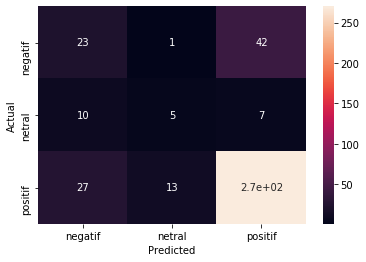

In [20]:
import seaborn as sn

confusion = pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion, annot=True)

In [21]:
# # Create XGB Classifier object
# xgb_clf = xgb.XGBClassifier(tree_method = "exact", predictor = "gpu_predictor", verbosity = 1, objective = "multi:softmax")

# # Create parameter grid
# # parameters = {"learning_rate": [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.01, 0.001],
# #                "gamma" : [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1, 1.5, 2, 3, 4, 6],
# #                "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20],
# #                "colsample_bytree": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
# #                "subsample": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
# #                "reg_alpha": [0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
# #                "reg_lambda": [1, 1.5, 2, 3, 4.5, 4, 5],
# #                "min_child_weight": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
# #                "n_estimators": [100, 250, 500, 1000],
# #                "num_boost_round": [100, 250, 500, 750, 1000]}

# parameters = {"learning_rate": [0.1, 0.01, 0.001],
#                "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
#                "max_depth": [2, 4, 7, 10],
#                "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
#                "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
#                "reg_alpha": [0, 0.5, 1],
#                "reg_lambda": [1, 1.5, 2, 3, 4.5],
#                "min_child_weight": [1, 3, 5, 7],
#                "n_estimators": [100, 250, 500, 1000]}

# from sklearn.model_selection import RandomizedSearchCV
# # Create RandomizedSearchCV Object
# xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = parameters, scoring = "f1_micro",
#                              cv = 10, verbose = 3, random_state = 40 )
           
# # Fit the model
# model_xgboost = xgb_rscv.fit(X_train_vector, y_train)

# # Model best estimators
# print("Learning Rate: ", model_xgboost.best_estimator_.get_params()["learning_rate"])
# print("Gamma: ", model_xgboost.best_estimator_.get_params()["gamma"])
# print("Max Depth: ", model_xgboost.best_estimator_.get_params()["max_depth"])
# print("Subsample: ", model_xgboost.best_estimator_.get_params()["subsample"])
# print("Colsample Bytree: ", model_xgboost.best_estimator_.get_params()["colsample_bytree"])
# print("Alpha: ", model_xgboost.best_estimator_.get_params()["reg_alpha"])
# print("Lamda: ", model_xgboost.best_estimator_.get_params()["reg_lambda"])
# print("Min Child Weight: ", model_xgboost.best_estimator_.get_params()["min_child_weight"])
# print("Number of Trees: ", model_xgboost.best_estimator_.get_params()["n_estimators"])